# Recurrent Switching Linear Dynamical System

This is an experimental example of a Recurrent Switching Linear Dynamical System (RSLDS) model. The notebook requires patches to RxInfer and ReactiveMP, which are condensed in the hidden blocks below.

In [17]:
### EXAMPLE_HIDDEN_BLOCK_START(RxInfer & ReactiveMP patches and extensions) ###
using ExponentialFamily, RxInfer, BayesBase, GraphPPL
import ReactiveMP: AbstractFactorNode, NodeInterface, IndexedNodeInterface, FactorNodeActivationOptions, Marginalisation,
 Deterministic, PredefinedNodeFunctionalForm,FunctionalDependencies, collect_functional_dependencies, activate!, functional_dependencies, 
 collect_latest_messages, collect_latest_marginals, marginalrule, rule, name, getinboundinterfaces, clustername, getdependecies,
 messagein, ManyOf, getvariable
import ExponentialFamily: getnaturalparameters, exponential_family_typetag
export Gate, GateNode

# Mixture Functional Form
struct Gate{N} end

ReactiveMP.as_node_symbol(::Type{<:Gate}) = :Gate
ReactiveMP.interfaces(::Type{<:Gate}) = Val((:out, :switch, :inputs))
ReactiveMP.alias_interface(::Type{<:Gate}, ::Int64, name::Symbol) = name
ReactiveMP.is_predefined_node(::Type{<:Gate}) = ReactiveMP.PredefinedNodeFunctionalForm()
ReactiveMP.sdtype(::Type{<:Gate}) = ReactiveMP.Deterministic()
ReactiveMP.collect_factorisation(::Type{<:Gate}, factorization) = GateNodeFactorisation()

struct GateNodeFactorisation end

struct GateNode{N} <: ReactiveMP.AbstractFactorNode
    out    :: ReactiveMP.NodeInterface
    switch :: ReactiveMP.NodeInterface
    inputs :: NTuple{N, ReactiveMP.IndexedNodeInterface}
end 

ReactiveMP.functionalform(factornode::GateNode{N}) where {N} = Gate{N}
ReactiveMP.getinterfaces(factornode::GateNode) = (factornode.out, factornode.switch, factornode.inputs...)
ReactiveMP.sdtype(factornode::GateNode) = ReactiveMP.Deterministic()

ReactiveMP.interfaceindices(factornode::GateNode, iname::Symbol)                       = (ReactiveMP.interfaceindex(factornode, iname),)
ReactiveMP.interfaceindices(factornode::GateNode, inames::NTuple{N, Symbol}) where {N} = map(iname -> ReactiveMP.interfaceindex(factornode, iname), inames)

ReactiveMP.interfaceindex(factornode::GateNode, iname::Symbol) = begin
    if iname === :out
        return 1
    elseif iname === :switch
        return 2
    elseif iname === :inputs
        return 3
    end
end

ReactiveMP.factornode(::Type{<:Gate}, interfaces, factorization) = begin
    outinterface = interfaces[findfirst(((name, variable),) -> name == :out, interfaces)]
    switchinterface = interfaces[findfirst(((name, variable),) -> name == :switch, interfaces)]
    inputinterfaces = filter(((name, variable),) -> name == :inputs, interfaces)
    N = length(inputinterfaces)
    return GateNode(ReactiveMP.NodeInterface(outinterface...), ReactiveMP.NodeInterface(switchinterface...), ntuple(i -> ReactiveMP.IndexedNodeInterface(i, ReactiveMP.NodeInterface(inputinterfaces[i]...)), N))
    
end

struct GateNodeInboundInterfaces end

ReactiveMP.getinboundinterfaces(::GateNode) = GateNodeInboundInterfaces()
ReactiveMP.clustername(::GateNodeInboundInterfaces) = :switch_inputs


struct GateNodeFunctionalDependencies <: FunctionalDependencies end

ReactiveMP.collect_functional_dependencies(::GateNode, ::Nothing) = GateNodeFunctionalDependencies()
ReactiveMP.collect_functional_dependencies(::GateNode, ::GateNodeFunctionalDependencies) = GateNodeFunctionalDependencies()
ReactiveMP.collect_functional_dependencies(::GateNode, ::Any) =
    error("The functional dependencies for GateNode must be either `Nothing` or `GateNodeFunctionalDependencies`")

ReactiveMP.activate!(factornode::GateNode, options::FactorNodeActivationOptions) = begin
    dependencies = ReactiveMP.collect_functional_dependencies(factornode, ReactiveMP.getdependecies(options))
    return ReactiveMP.activate!(dependencies, factornode, options)
end


ReactiveMP.functional_dependencies(::GateNodeFunctionalDependencies, factornode::GateNode{N}, interface, iindex::Int) where {N} = begin
    message_dependencies = if iindex === 1
        # output depends on input messages:
        (factornode.inputs, )
    elseif iindex === 2
        # switch depends on:
        (factornode.out, factornode.inputs)
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.out, )
    else
        error("Bad index in functional_dependencies for MixtureNode")
    end

    marginal_dependencies = if iindex === 1
        # output depends on:
        (factornode.switch, )
    elseif iindex === 2
        # switch depends on:
        ( )
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.switch,)
    else
        error("Bad index in functional_dependencies for GateNode")
    end

    return message_dependencies, marginal_dependencies
end


ReactiveMP.collect_latest_messages(::GateNodeFunctionalDependencies, factornode::GateNode{N}, messages::Tuple{NodeInterface}) where {N} = begin
    outputinterface = messages[1]

    msgs_names = Val{(name(outputinterface),)}()
    msgs_observable = combineLatestUpdates((messagein(outputinterface),), PushNew())
    return msgs_names, msgs_observable
end

ReactiveMP.collect_latest_marginals(::GateNodeFunctionalDependencies, factornode::GateNode{N}, marginals::Tuple{NodeInterface}) where {N} = begin
    switchinterface = marginals[1]

    marginal_names = Val{(name(switchinterface),)}()
    marginal_observable = combineLatestUpdates((
        getmarginal(getvariable(switchinterface), IncludeAll()),
    ), PushNew())

    return marginal_names, marginal_observable
end

ReactiveMP.collect_latest_marginals(::GateNodeFunctionalDependencies, factornode::GateNode{N}, marginals::NTuple{N,IndexedNodeInterface}) where {N} = begin
    inputsinterfaces = marginals
    
    marginal_names = Val{(name(first(inputsinterfaces)),)}()
    marginal_observable = combineLatest(map(input -> getmarginal(getvariable(input), IncludeAll()), inputsinterfaces), PushNew()) |> map_to((ManyOf(map(input -> getmarginal(getvariable(input), IncludeAll()), inputsinterfaces)),))
    
    return marginal_names, marginal_observable
end

ReactiveMP.collect_latest_messages(::GateNodeFunctionalDependencies, factornode::GateNode{N}, messages::Tuple{NodeInterface, NTuple{N, IndexedNodeInterface}}) where {N} = begin
    output_or_switch_interface = messages[1]
    inputsinterfaces = messages[2]

    msgs_names = Val{(name(output_or_switch_interface), name(inputsinterfaces[1]))}()
    msgs_observable =
        combineLatest(
            (messagein(output_or_switch_interface), combineLatest(map(input -> messagein(input), inputsinterfaces), PushNew())),
            PushNew()
        ) |> map_to((
            messagein(output_or_switch_interface), 
            ManyOf(map(input -> messagein(input), inputsinterfaces))
        ))
    
    return msgs_names, msgs_observable
end

ReactiveMP.collect_latest_messages(::GateNodeFunctionalDependencies, factornode::GateNode{N}, messages::Tuple{NTuple{N,IndexedNodeInterface}}) where {N} = begin
    inputsinterfaces = messages[1]
    
    msgs_names = Val{(name(first(inputsinterfaces)),)}()
    msgs_observable = combineLatest(map(input -> messagein(input), inputsinterfaces), PushNew()) |> map_to((ManyOf(map(input -> messagein(input), inputsinterfaces)),))
    
    return msgs_names, msgs_observable
end


ReactiveMP.marginalrule(fform::Type{<:Gate}, on::Val{:switch_inputs}, mnames::Any, messages::Any, qnames::Nothing, marginals::Nothing, meta::Nothing, __node::Any) = begin
    # m_out = getdata(messages[1])
    m_switch = getdata(messages[2])
    m_inputs = getdata.(messages[3:end])


    return FactorizedJoint((m_inputs..., m_switch))
end

ReactiveMP.@rule Gate(:out, Marginalisation) (q_switch::Any, m_inputs::ManyOf{N, Any}) where {N} = begin
    return MixtureDistribution(collect(m_inputs), probvec(q_switch))
end


ReactiveMP.@rule Gate(:switch, Marginalisation) (m_out::Any, m_inputs::ManyOf{N, Any}) where {N} = begin
    logscales = map(input -> compute_logscale(prod(GenericProd(),m_out,input), m_out, input), m_inputs)
    p = softmax(collect(logscales))
    return Multinomial(1, p)
end


ReactiveMP.@rule Gate((:inputs, k), Marginalisation) (m_out::Any, q_switch::Any,) = begin
    z = probvec(q_switch)[k]
    ef_out = convert(ExponentialFamilyDistribution, m_out)
    η      = getnaturalparameters(ef_out)
    ef_opt = ExponentialFamilyDistribution(exponential_family_typetag(ef_out), η * z)

    return convert(Distribution, ef_opt)
end


ReactiveMP.@rule typeof(*)(:out, Marginalisation) (m_A::PointMass, m_in::MixtureDistribution, meta::Any) = begin 
    comps = BayesBase.components(m_in)
    new_components = similar(comps)
    @inbounds for (i,component) in enumerate(comps)
        new_components[i] = @call_rule typeof(*)(:out, Marginalisation) (m_A = m_A, m_in = component, meta = meta)
    end
    dist = MixtureDistribution(new_components, BayesBase.weights(m_in))
    return dist
end

ReactiveMP.@rule typeof(dot)(:out, Marginalisation) (m_in1::MixtureDistribution, m_in2::PointMass, meta::Any) = begin 
    comps = BayesBase.components(m_in1)
    new_components = []
    @inbounds for (i, component) in enumerate(comps)
        push!(new_components, @call_rule typeof(dot)(:out, Marginalisation) (m_in1 = component, m_in2 = m_in2, meta = meta))
    end
    
    mixture = MixtureDistribution(new_components, BayesBase.weights(m_in1))

    return mixture
end



@rule typeof(dot)(:in1, Marginalisation) (m_out::MixtureDistribution, m_in2::PointMass, meta::Any) = begin 
    comps = BayesBase.components(m_out)
    weights = BayesBase.weights(m_out)
    new_comps = []
    for (comp, weight) in zip(comps, weights)
        new_comp = @call_rule typeof(dot)(:in1, Marginalisation) (m_out = comp, m_in2 = m_in2, meta = meta)
        push!(new_comps, new_comp)
    end
    return MixtureDistribution(new_comps, weights)
end

function BayesBase.prod(::BayesBase.UnspecifiedProd, left::GaussianDistributionsFamily, right::MixtureDistribution)
    comps = BayesBase.components(right)
    weights = BayesBase.weights(right)
    new_comps = []
    for comp in comps
        new_comp = prod(GenericProd(),left, comp)
        push!(new_comps, new_comp)
    end
    
    return MixtureDistribution(new_comps, weights)
end

BayesBase.prod(::BayesBase.UnspecifiedProd, left::MixtureDistribution, right::GaussianDistributionsFamily) = prod(GenericProd(),right, left)
BayesBase.paramfloattype(::MixtureDistribution) = Float64


import ExponentialFamily.LogExpFunctions: logsumexp
function BayesBase.prod(::GenericProd, left::Categorical, right::Multinomial)
    @assert right.n == 1
    right_cat = Categorical(right.p)

    p = prod(GenericProd(), left, right_cat).p 
    return Multinomial(1, p)

end



BayesBase.prod(::GenericProd, left::Multinomial, right::Categorical) = prod(GenericProd(), right, left)
function BayesBase.prod(::GenericProd, left::Multinomial, right::Multinomial) 
    @assert left.n == right.n

    p = left.p .* right.p
    p = p ./ sum(p)
    return Multinomial(left.n, p)
end

BayesBase.prod(::BayesBase.UnspecifiedProd, left::Multinomial, right::Multinomial) = prod(GenericProd(), left, right)


function BayesBase.compute_logscale(dist1::Multinomial, dist2::Multinomial, dist3::Multinomial) 
    logp1 = log.(dist1.p) - log(dist1.p[end])
    logp2 = log.(dist2.p) - log(dist2.p[end])
    logp3 = log.(dist3.p) - log(dist3.p[end])
    return logsumexp(logp1) - logsumexp(logp2) - logsumexp(logp3)
end

BayesBase.compute_logscale(d1::ExponentialFamily.WishartFast, d2::ExponentialFamily.WishartFast, d3::ExponentialFamily.WishartFast) = begin
    return logpartition(convert(ExponentialFamilyDistribution, d1)) - logpartition(convert(ExponentialFamilyDistribution, d2)) - logpartition(convert(ExponentialFamilyDistribution, d3))
end


ExponentialFamily.probvec(d::Multinomial) = d.p

@rule ContinuousTransition(:W, Marginalisation) (q_y_x::MultivariateNormalDistributionsFamily, q_a::MixtureDistribution, meta::Any) = begin 
    q_a_normal = convert(promote_variate_type(typeof(mean(q_a)), NormalMeanPrecision), mean(q_a), precision(q_a))
    return @call_rule ContinuousTransition(:W, Marginalisation) (q_y_x = q_y_x, q_a = q_a_normal, meta = meta)
end

@rule ContinuousTransition(:y, Marginalisation) (m_x::MultivariateNormalDistributionsFamily, q_a::MixtureDistribution, q_W::Any, meta::Any) = begin 
    q_a_normal = convert(promote_variate_type(typeof(mean(q_a)), NormalMeanPrecision), mean(q_a), precision(q_a))
    return @call_rule ContinuousTransition(:y, Marginalisation) (m_x = m_x, q_a = q_a_normal, q_W = q_W, meta = meta)
end


@rule ContinuousTransition(:a, Marginalisation) (q_y_x::MultivariateNormalDistributionsFamily, q_a::MixtureDistribution, q_W::Any, meta::Any) = begin 
    q_a_normal = convert(promote_variate_type(typeof(mean(q_a)), NormalMeanPrecision), mean(q_a), precision(q_a))
    return @call_rule ContinuousTransition(:a, Marginalisation) (q_y_x = q_y_x, q_a = q_a_normal, q_W = q_W, meta = meta)
end

@rule ContinuousTransition(:x, Marginalisation) (m_y::MultivariateNormalDistributionsFamily , q_a::MixtureDistribution, q_W::Any, meta::Any) = begin 
    q_a_normal = convert(promote_variate_type(typeof(mean(q_a)), NormalMeanPrecision), mean(q_a), precision(q_a))
    return @call_rule ContinuousTransition(:x, Marginalisation) (m_y = m_y, q_a = q_a_normal, q_W = q_W, meta = meta)
end

@rule ContinuousTransition(:y, Marginalisation) (m_x::MixtureDistribution, q_a::MultivariateNormalDistributionsFamily, q_W::Any, meta::Any) = begin 
    m_x_normal = convert(promote_variate_type(typeof(mean(m_x)), NormalMeanPrecision), mean(m_x), precision(m_x))
    return @call_rule ContinuousTransition(:y, Marginalisation) (m_x = m_x_normal, q_a = q_a, q_W = q_W, meta = meta)
end


@marginalrule ContinuousTransition(:y_x) (m_y::MultivariateNormalDistributionsFamily, m_x::MixtureDistribution, q_a::MultivariateNormalDistributionsFamily, q_W::Any, meta::Any) = begin 
    m_x_normal = convert(promote_variate_type(typeof(mean(m_x)), NormalMeanPrecision), mean(m_x), precision(m_x))
    return @call_marginalrule ContinuousTransition(:y_x) (m_y = m_y, m_x = m_x_normal, q_a = q_a, q_W = q_W, meta = meta)
end

@rule typeof(+)(:out, Marginalisation) (m_in1::MultivariateNormalDistributionsFamily, m_in2::MixtureDistribution, ) = begin 
    return @call_rule typeof(+)(:out, Marginalisation) (m_in1 = m_in1, m_in2 = convert(promote_variate_type(typeof(mean(m_in2)), NormalMeanPrecision), mean(m_in2), precision(m_in2)))
end

@rule typeof(+)(:in1, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in2::MixtureDistribution, ) = begin 
    return @call_rule typeof(+)(:in1, Marginalisation) (m_out = convert(promote_variate_type(typeof(mean(m_out)), NormalMeanPrecision), mean(m_out), precision(m_out)), m_in2 = convert(promote_variate_type(typeof(mean(m_in2)), NormalMeanPrecision), mean(m_in2), precision(m_in2)))
end

@rule DiscreteTransition(:out, Marginalisation) (m_in::Multinomial, q_a::DirichletCollection, ) = begin 
    @assert m_in.n == 1
    p = probvec(m_in)
    m_in_cat = Categorical(p)
    return @call_rule DiscreteTransition(:out, Marginalisation) (m_in = m_in_cat, q_a = q_a)
end

@rule DiscreteTransition(:in, Marginalisation) (m_out::Multinomial, q_a::DirichletCollection, ) = begin 
    @assert m_out.n == 1
    p = probvec(m_out)
    m_out_cat = Categorical(p)
    return @call_rule DiscreteTransition(:in, Marginalisation) (m_out = m_out_cat, q_a = q_a)
end

@marginalrule DiscreteTransition(:out_in) (m_out::Multinomial, m_in::Multinomial, q_a::DirichletCollection, ) = begin 
    @assert m_out.n == 1 && m_in.n == 1
    p_out = probvec(m_out)
    p_in = probvec(m_in)
    m_out_cat = Categorical(p_out)
    m_in_cat = Categorical(p_in)
    return @call_marginalrule DiscreteTransition(:out_in) (m_out = m_out_cat, m_in = m_in_cat, q_a = q_a)
end


Base.length(d::MixtureDistribution) = length(d.components)
Base.ndims(d::MixtureDistribution) = first(size(first(d.components)))

ExponentialFamily.probvec(d::Multinomial) = d.p

BayesBase.entropy(d::MixtureDistribution) = mapreduce((c,w) -> w * BayesBase.entropy(c), +, d.components, d.weights)

BayesBase.mean(f::F, itr::MixtureDistribution) where {F} = mapreduce((c,w) -> w * mean(f, c), +, itr.components, itr.weights)

function create_P_matrix(n_switches)
    P = zeros(n_switches, n_switches)
    for i in 1:n_switches
        P[i,:] = 0.5 * ones(n_switches)
        P[i,i] = 1.0
    end
    return P
end

function BayesBase.mean(mixture::MixtureDistribution)
    component_means = mean.(BayesBase.components(mixture))
    component_weights = BayesBase.weights(mixture)
    return mapreduce((m,w) -> w*m, +, component_means, component_weights)
end

function BayesBase.cov(mixture::MixtureDistribution)
    component_cov = cov.(BayesBase.components(mixture))
    component_means = mean.(BayesBase.components(mixture))
    component_weights = BayesBase.weights(mixture)
    mixture_mean = mean(mixture)
    return mapreduce((v,m,w) -> w*(v + m*m'), +, component_cov, component_means, component_weights) - mixture_mean*mixture_mean'
end

BayesBase.precision(mixture::MixtureDistribution) = inv(cov(mixture))

function BayesBase.var(mixture::MixtureDistribution)
    component_vars = var.(BayesBase.components(mixture))
    component_means = mean.(BayesBase.components(mixture))
    component_weights = BayesBase.weights(mixture)
    mixture_mean = mean(mixture)
    return mapreduce((v,m,w) -> w*(v + m.^2), +, component_vars, component_means, component_weights) - mixture_mean.^2
end

nothing # hide
### EXAMPLE_HIDDEN_BLOCK_END ###

In [18]:
### EXAMPLE_HIDDEN_BLOCK_START(RSLDS Model Specification) ###
import ExponentialFamily: softmax

"""
    RSLDSHyperparameters{T}

Structure containing hyperparameters for the Recurrent Switching Linear Dynamical System (RSLDS) model.

# Fields
- `a_w::T = 2.0`: Shape parameter for the Gamma prior on precision parameter w (when n_switches=1)
- `b_w::T = 2.0`: Rate parameter for the Gamma prior on precision parameter w (when n_switches=1)
- `Ψ_w::Matrix{T}`: Scale matrix for the Wishart prior on precision matrix w (when n_switches>1)
- `Ψ_R::Union{Matrix{T}, T}`: Scale matrix/parameter for the Wishart/Gamma prior on observation precision
- `ν_R::T`: Degrees of freedom for the Wishart prior on observation precision
- `α::Matrix{T}`: Parameter matrix for the Dirichlet prior on transition probabilities
- `C::Matrix{T}`: Observation matrix mapping latent states to observations
"""
Base.@kwdef struct RSLDSHyperparameters{T} 
   a_w::T = 2.0
   b_w::T = 2.0
   Ψ_w::Matrix{T}
   Ψ_R::Union{Matrix{T}, T}
   ν_R::T
   α::Matrix{T} 
   C::Matrix{T}
end

"""
    get_hyperparameters(hyperparameters::RSLDSHyperparameters)

Extract all hyperparameters from the RSLDSHyperparameters structure.

# Arguments
- `hyperparameters::RSLDSHyperparameters`: Structure containing the hyperparameters

# Returns
A tuple containing all hyperparameters in the order: a_w, b_w, Ψ_w, Ψ_R, ν_R, α, C
"""
function get_hyperparameters(hyperparameters::RSLDSHyperparameters)
    return hyperparameters.a_w, hyperparameters.b_w, hyperparameters.Ψ_w, hyperparameters.Ψ_R, hyperparameters.ν_R, hyperparameters.α, hyperparameters.C
end

"""
    default_hyperparameters(n_switches, obs_dim, dim_latent)

Create a default set of hyperparameters for the RSLDS model.

# Arguments
- `n_switches`: Number of switching states in the model
- `obs_dim`: Dimension of the observation space
- `dim_latent`: Dimension of the latent state space

# Returns
An RSLDSHyperparameters structure with default values
"""
function default_hyperparameters(n_switches, obs_dim, dim_latent)
    return RSLDSHyperparameters(
        a_w = 2.0,
        b_w = 2.0,
        Ψ_w = diageye(n_switches),
        Ψ_R = diageye(obs_dim),
        ν_R = obs_dim + 2.0,
        α = ones(n_switches+1, n_switches+1),
        C = diageye(obs_dim,dim_latent)
    )
end


@model function rslds_model_learning(obs,n_obs,n_switches, dim_latent, η, Ψ, hyperparameters, learn_observation_covariance)
    local H,A,Λ,u
    transformation  = (x) -> reshape(x, (dim_latent, dim_latent))
    transformation2 = (x) -> reshape(x, (n_switches, dim_latent))
    ##Hyperparameters
    a_w, b_w, Ψ_w, Ψ_R,ν_R, α, C = get_hyperparameters(hyperparameters)
    ## Priors on the parameters 
    if n_switches == 1
        w ~ GammaShapeRate(a_w, b_w)
    else
        w ~ Wishart(n_switches+2,Ψ_w)
    end 

    if learn_observation_covariance
        if n_obs == 1
            R ~ GammaShapeRate(ν_R, Ψ_R)
        else
            R ~ Wishart(ν_R, Ψ_R) 
        end
    else
        R = Ψ_R
    end
    
    for k in 1:n_switches+1
        H[k] ~ MvNormalMeanCovariance(zeros(dim_latent^2), diageye(dim_latent^2))
        Λ[k] ~ Wishart(dim_latent+2, diageye(dim_latent))
    end
    P ~ DirichletCollection(α)
    ϕ ~ MvNormalMeanCovariance(zeros(dim_latent*n_switches), diageye(dim_latent*n_switches))
    ## States Initialisation 
    x[1] ~ MvNormalMeanCovariance(zeros(dim_latent), diageye(dim_latent))
    for t in eachindex(obs)  
        ## Recurrent Layer
        if n_switches == 1
            u[t] ~ softdot(ϕ, x[t], w)
        else
            u[t] ~ ContinuousTransition(x[t], ϕ, w) where {meta = CTMeta(transformation2)}
        end     
        s[t] ~ MultinomialPolya(1, u[t]) where {dependencies = RequireMessageFunctionalDependencies(ψ = convert(promote_variate_type(typeof(η), NormalWeightedMeanPrecision), η, Ψ))}   
        s[t+1] ~ DiscreteTransition(s[t], P)
        ##Transition Layer
        A[t] := Gate(switch=s[t+1], inputs=H)
        B[t] := Gate(switch=s[t+1], inputs=Λ)
        x[t+1] ~ ContinuousTransition(x[t], A[t], B[t]) where {meta = CTMeta(transformation)}
        ## Observation Layer
        obs[t] ~ MvNormalMeanPrecision(C*x[t+1], R)
    end
end

@constraints  function rslds_learning_constraints(learn_observation_covariance)
    if learn_observation_covariance
        q(x,s,u,ϕ,w,P,H,A,Λ,B,R) = q(x,u)q(A)q(s)q(ϕ)q(w)q(P)q(H)q(Λ)q(B)q(R)
    else
        q(x,s,u,ϕ,w,P,H,A,Λ,B) = q(x,u)q(A)q(s)q(ϕ)q(w)q(P)q(H)q(Λ)q(B)
    end
end

@initialization function rslds_learning_initmarginals(n_switches, dim_latent, obs_dim, learn_observation_covariance; rng = StableRNG(42))    
    q(x) = vague(MvNormalWeightedMeanPrecision, dim_latent)
    q(s) = Multinomial(1,softmax(randn(rng, n_switches+1)))
    q(ϕ) = vague(MvNormalWeightedMeanPrecision, dim_latent*(n_switches))
    if n_switches == 1
        q(w) = vague(GammaShapeRate)
    else
        q(w) = vague(Wishart, n_switches)   
    end
    q(A) = vague(MvNormalWeightedMeanPrecision, dim_latent^2)
    q(P) = DirichletCollection(ones(n_switches+1,n_switches+1))
    q(Λ) = vague(Wishart, dim_latent)
    q(H) = vague(MvNormalWeightedMeanPrecision, dim_latent^2)
    q(B) = vague(Wishart, dim_latent)
    if learn_observation_covariance
        if obs_dim == 1
            q(R) = vague(GammaShapeRate)
        else
            q(R) = Wishart(obs_dim+2, diageye(obs_dim))
        end
    end
end;



"""
    fit_rslds(data, n_switches, dim_latent, n_obs; kwargs...)

Fit a Recurrent Switching Linear Dynamical System (RSLDS) model to the provided data.

# Arguments
- `data`: Time series observation data
- `n_switches`: Number of switching states in the model. Note: The user provides the total number of states,
  but internally we use (n_switches-1) because the MultinomialPolya distribution adds an extra dimension
  to represent the recurrent influence on state transitions.
- `dim_latent`: Dimension of the latent state space
- `n_obs`: Dimension of the observation space

# Keyword Arguments
- `iterations::Int = 60`: Number of inference iterations
- `η = nothing`: Mean parameter for the functional dependency in MultinomialPolya
- `Ψ = nothing`: Precision parameter for the functional dependency in MultinomialPolya
- `hyperparameters = nothing`: Custom hyperparameters for the model
- `progress::Bool = false`: Whether to show progress during inference
- `learn_observation_covariance::Bool = false`: Whether to learn the observation covariance

# Returns
The result of the inference procedure
"""
function fit_rslds(data, n_switches, dim_latent, n_obs; iterations = 60, η = nothing, Ψ = nothing, hyperparameters = nothing, progress = false, learn_observation_covariance = false)
    @assert n_switches > 1 "n_switches must be greater than 1"
    # We subtract 1 from n_switches because the MultinomialPolya distribution
    # internally adds an extra dimension to represent the recurrent influence
    # on state transitions. This convention allows the model to maintain the
    # correct dimensionality while incorporating the recurrent dynamics.
    n_switches = n_switches - 1

    if hyperparameters === nothing
        hyperparameters = default_hyperparameters(n_switches, length(data[1]), dim_latent)
    end

    if η === nothing
        if n_switches == 1
            η = 0.0
        else
            η = zeros(n_switches)
        end
    end
    if Ψ === nothing
        if n_switches == 1
            Ψ = 0.0001
        else
            Ψ = 0.0001*diageye(n_switches)
        end
    end
    model = rslds_model_learning(n_obs = n_obs, n_switches = n_switches, dim_latent = dim_latent, η = η, Ψ = Ψ, hyperparameters = hyperparameters, learn_observation_covariance = learn_observation_covariance)
    constraints = rslds_learning_constraints(learn_observation_covariance)
    initmarginals = rslds_learning_initmarginals(n_switches, dim_latent, n_obs, learn_observation_covariance)
    
    return infer(model = model, data = (obs=data, ), constraints = constraints, initialization = initmarginals, iterations = iterations,
    showprogress = progress,
    returnvars = KeepEach(),
    free_energy = true,
    options = (limit_stack_depth = 100,)
    )
end

# 

function states_to_categorical(states)
    return [argmax(states[t].p) for t in 1:length(states)]
end

nothing # hide
### EXAMPLE_HIDDEN_BLOCK_END ###

In [19]:
### EXAMPLE_HIDDEN_BLOCK_START(Generating Synthetic Data) ###
using StableRNGs

function generate_switching_data(T, A1, A2, c, Q, R, x_0;rng = StableRNG(42))
    # Initialize arrays to store states and observations
    x = zeros(2, T)  # State matrix: 2 dimensions × T timesteps
    y = zeros(2, T)  # Observation matrix: 2 dimensions × T timesteps
    
    # Set initial state
    x[:,1] = x_0
    
    # Generate state transitions and observations
    for t in 2:T
        # Switch dynamics multiple times through the sequence
        if t < T/3 || (t >= T/2 && t < 3T/4)
            x[:,t] = A2 * x[:,t-1] + rand(rng,MvNormal(zeros(2), Q))  # First regime
        else
            x[:,t] = A1 * x[:,t-1] + rand(rng,MvNormal(zeros(2), Q))  # Second regime
        end
        
        # Generate observation from current state
        y[:,t] = c * x[:,t] + rand(rng,MvNormal(zeros(2), R))
    end

    return x, y
end
        

# System parameters
T = 500  # Time horizon
θ = π / 15  # Rotation angle

# Define system matrices
A1 = [cos(θ) -sin(θ); sin(θ) cos(θ)]    # Rotation matrix
A2 = [0.4 -0.01; 0.01 0.2]         
c = [0.6 -0.02; -0.02 0.3]                   # Observation/distortion matrix

# Noise parameters
Q = [1.0 0.0; 0.0 1.0]                   # State noise covariance
R =  [1.0 0.0; 0.0 1.0]            # Observation noise variance
x_0 = [0.0, 0.0]                         # Initial state vector

# Generate synthetic data
x, y = generate_switching_data(T, A1, A2, c, Q, R, x_0)
y = [y[:,i] for i in 1:T]
x = [x[:,i] for i in 1:T]

nothing # hide
### EXAMPLE_HIDDEN_BLOCK_END ###

In [20]:
hyperparameters = RSLDSHyperparameters(
    a_w = 0.01,
    b_w = 0.01,
    Ψ_w = 10.0*diageye(2), # n-1  
    Ψ_R = inv(R),
    ν_R = 4.0,
    α = ones(2,2), # n
    C = c
) 

RSLDSHyperparameters{Float64}(0.01, 0.01, [10.0 0.0; 0.0 10.0], [1.0 0.0; 0.0 1.0], 4.0, [1.0 1.0; 1.0 1.0], [0.6 -0.02; -0.02 0.3])

In [21]:
rslds_result = fit_rslds(y, 2, 2, 2; iterations = 150, hyperparameters = hyperparameters, progress = true)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


Inference results:
  Posteriors       | available for (ϕ, w, P, A, s, H, Λ, B, u, x)
  Free Energy:     | Real[4.16074e5, 74909.3, 2785.86, 1976.14, 1836.8, 1843.09, 1882.52, 1922.84, 1962.31, 2000.64  …  1723.37, 1724.07, 1724.75, 1725.42, 1726.08, 1726.73, 1727.36, 1727.98, 1728.58, 1729.18]


In [23]:
using Plots

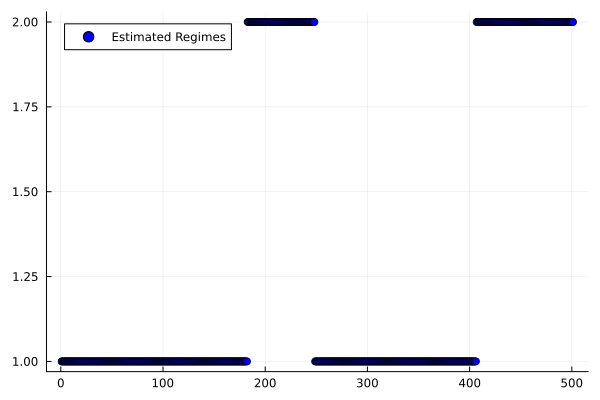

In [25]:
switching_state_posterior = rslds_result.posteriors[:s][end];
states = states_to_categorical(switching_state_posterior);
scatter(states, label="Estimated Regimes", color="blue", linewidth=2)

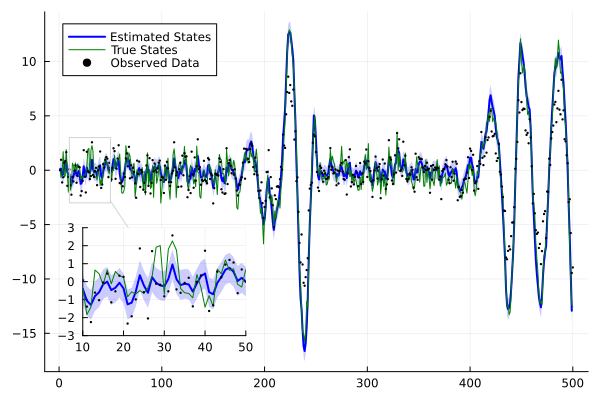

In [26]:
continuous_state_posterior = rslds_result.posteriors[:x][end];
index = 1
from = 1
to = 500

m_continuous = getindex.(mean.(continuous_state_posterior), index);
var_continuous = getindex.(var.(continuous_state_posterior), index);
plot(m_continuous[from+1:to], ribbon=sqrt.(var_continuous[from+1:to]), label="Estimated States", color="blue",fillalpha=0.2, linewidth=2)
plot!(getindex.(x,index)[from:to], label="True States", color="green", linewidth=1)
scatter!(getindex.(y,index)[from:to], label="Observed Data", color="black", ms=1.3)
lens!([10,50],[-3, 3],inset = (1, bbox(0.07, 0.6, 0.3, 0.3)), )


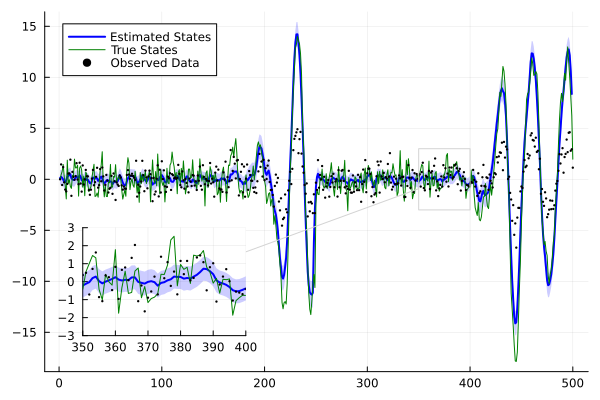

In [27]:
index = 2
m_continuous = getindex.(mean.(continuous_state_posterior), index);
var_continuous = getindex.(var.(continuous_state_posterior), index);
plot(m_continuous[from+1:to], ribbon=sqrt.(var_continuous[from+1:to]), label="Estimated States", color="blue",fillalpha=0.2, linewidth=2)
plot!(getindex.(x,index)[from:to], label="True States", color="green", linewidth=1)
scatter!(getindex.(y,index)[from:to], label="Observed Data", color="black", ms=1.3)
lens!([350,400],[-3, 3],inset = (1, bbox(0.07, 0.6, 0.3, 0.3)), )


In [28]:
println("Estimated continuous transition matrices:")
println("----------------------------------------")
for i in 1:length(rslds_result.posteriors[:H][end])
    println("Matrix $i:")
    println(reshape(mean(rslds_result.posteriors[:H][end][i]), 2, 2))
    println()
end

Estimated continuous transition matrices:
----------------------------------------
Matrix 1:
[0.46780922322784446 -0.3381430615043983; 0.16605496112413132 0.5863885239695865]

Matrix 2:
[0.9799054780405537 -0.2104304648199258; 0.1890960349335034 0.9800888588906277]



In [29]:
println("Estimated discrete transition matrix for HMM layer:")
println("----------------------------------------")
println(mean(rslds_result.posteriors[:P][end]))

Estimated discrete transition matrix for HMM layer:
----------------------------------------
[0.991096105854864 0.012611037456523706; 0.008903894145136025 0.9873889625434763]
